In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_d(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.tanh(x) ** 2

In [ ]:
def xavier_init(fan_in, fan_out):
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_out, fan_in))

In [ ]:
def RMSELoss(pred, target):
    return np.sqrt(np.mean((pred - target) ** 2))

In [ ]:
class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.init_weights()

    def init_weights(self):
        concat_size = self.input_size + self.hidden_size
        self.W_f = np.random.randn(self.hidden_size, concat_size) * 0.1
        self.b_f = np.zeros((self.hidden_size,))
        self.W_i = np.random.randn(self.hidden_size, concat_size) * 0.1
        self.b_i = np.zeros((self.hidden_size,))
        self.W_o = np.random.randn(self.hidden_size, concat_size) * 0.1
        self.b_o = np.zeros((self.hidden_size,))
        self.W_c = np.random.randn(self.hidden_size, concat_size) * 0.1
        self.b_c = np.zeros((self.hidden_size,))

    def forward(self, x_t, h_prev, c_prev):
        h_x_concat = np.concatenate([h_prev, x_t])

        f_t = sigmoid(np.dot(self.W_f, h_x_concat) + self.b_f)
        i_t = sigmoid(np.dot(self.W_i, h_x_concat) + self.b_i)
        o_t = sigmoid(np.dot(self.W_o, h_x_concat) + self.b_o)
        c_t_tilda = tanh(np.dot(self.W_c, h_x_concat) + self.b_c)
        c_t = f_t * c_prev + i_t * c_t_tilda
        h_t = o_t * tanh(c_t)

        self.cache = {
            "x_t": x_t,
            "h_prev": h_prev,
            "c_prev": c_prev,
            "f_t": f_t,
            "i_t": i_t,
            "o_t": o_t,
            "c_t_tilda": c_t_tilda,
            "c_t": c_t,
            "h_x_concat": h_x_concat
        }

        return h_t, c_t

In [ ]:
#sanity check for LSTMCell
input_size, hidden_size = 4, 3
cell = LSTMCell(input_size, hidden_size)
x_t = np.random.randn(input_size)
h_prev = np.random.randn(hidden_size)
c_prev = np.random.randn(hidden_size)

h_t, c_t = cell.forward(x_t, h_prev, c_prev)

print("h_t shape:", h_t.shape)
print("c_t shape:", c_t.shape)
print("Gate outputs in [0,1]? ",
      np.all(cell.cache["f_t"] >= 0) and np.all(cell.cache["f_t"] <= 1),
      np.all(cell.cache["i_t"] >= 0) and np.all(cell.cache["i_t"] <= 1),
      np.all(cell.cache["o_t"] >= 0) and np.all(cell.cache["o_t"] <= 1))
c_t_tilda = cell.cache["c_t_tilda"]
print("c_t_tilda range:", c_t_tilda.min(), "to", c_t_tilda.max())

h_t shape: (3,)
c_t shape: (3,)
Gate outputs in [0,1]?  True True True
c_t_tilda range: -0.1504938949693878 to -0.11926766810244076


In [ ]:
class LSTM_BPTT:
    def __init__(self, input_size=4, hidden_size=32, output_size=10):
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        self.W_out = np.random.randn(output_size, hidden_size) * 0.1
        self.b_out = np.zeros((output_size,))

    def forward_sequence(self, input_sequence):
        h_t = np.zeros(self.hidden_size)
        c_t = np.zeros(self.hidden_size)
        self.cache_sequence = []

        for x_t in input_sequence:
            h_t, c_t = self.lstm_cell.forward(x_t, h_t, c_t)
            self.cache_sequence.append((h_t, c_t, self.lstm_cell.cache))

        output = np.dot(self.W_out, h_t) + self.b_out
        self.last_h_t = h_t
        return output

    def backward(self, dL_dy):
        #gradients of the output layer
        dL_dW_out = np.outer(dL_dy, self.last_h_t)
        dL_db_out = dL_dy.copy()

        dL_dh_t = np.dot(self.W_out.T, dL_dy)

        dW_f = np.zeros_like(self.lstm_cell.W_f)
        dW_i = np.zeros_like(self.lstm_cell.W_i)
        dW_o = np.zeros_like(self.lstm_cell.W_o)
        dW_c = np.zeros_like(self.lstm_cell.W_c)
        db_f = np.zeros_like(self.lstm_cell.b_f)
        db_i = np.zeros_like(self.lstm_cell.b_i)
        db_o = np.zeros_like(self.lstm_cell.b_o)
        db_c = np.zeros_like(self.lstm_cell.b_c)

        dh_next = dL_dh_t
        dc_next = np.zeros(self.hidden_size)

        for t in reversed(range(len(self.cache_sequence))):
            h_t, c_t, cache = self.cache_sequence[t]
            x_t = cache["x_t"]
            h_prev = cache["h_prev"]
            c_prev = cache["c_prev"]
            f_t = cache["f_t"]
            i_t = cache["i_t"]
            o_t = cache["o_t"]
            c_t_tilda = cache["c_t_tilda"]
            h_x_concat = cache["h_x_concat"]

            # gate derivatives
            do = dh_next * np.tanh(c_t) * sigmoid_d(np.dot(self.lstm_cell.W_o, h_x_concat) + self.lstm_cell.b_o)
            dc = dh_next * o_t * tanh_d(c_t) + dc_next
            df = dc * c_prev * sigmoid_d(np.dot(self.lstm_cell.W_f, h_x_concat) + self.lstm_cell.b_f)
            di = dc * c_t_tilda * sigmoid_d(np.dot(self.lstm_cell.W_i, h_x_concat) + self.lstm_cell.b_i)
            dc_tilda = dc * i_t * tanh_d(np.dot(self.lstm_cell.W_c, h_x_concat) + self.lstm_cell.b_c)

            dW_f += np.outer(df, h_x_concat)
            dW_i += np.outer(di, h_x_concat)
            dW_o += np.outer(do, h_x_concat)
            dW_c += np.outer(dc_tilda, h_x_concat)

            db_f += df
            db_i += di
            db_o += do
            db_c += dc_tilda

            dz = (
                np.dot(self.lstm_cell.W_f.T, df) +
                np.dot(self.lstm_cell.W_i.T, di) +
                np.dot(self.lstm_cell.W_o.T, do) +
                np.dot(self.lstm_cell.W_c.T, dc_tilda)
            )
            dh_next = dz[:self.hidden_size]
            dc_next = dc * f_t

        return [
            dL_dW_out, dL_db_out,
            dW_f, db_f,
            dW_i, db_i,
            dW_o, db_o,
            dW_c, db_c
        ]

In [ ]:
def extract_data(zip_path="/content/drive/MyDrive/Car_data.zip", extract_to="car_data"):
    import os
    import zipfile

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    csv_files = []
    for root, dirs, files in os.walk(extract_to):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    return sorted(csv_files)

In [ ]:
input_cols = ['Local_X', 'Local_Y', 'v_Vel', 'v_Acc']
target_cols = ['Local_X', 'Local_Y']

In [ ]:
def load_sequences_from_file(file_path):
    try:
        df = pd.read_csv(file_path)
        if df.shape[0] != 67:
            return None
        input_seq = df[input_cols].iloc[:62].values
        target_seq = df[target_cols].iloc[62:].values
        return input_seq, target_seq
    except Exception:
        return None

def load_all_sequences(csv_files):
    sequences = []
    for file in sorted(csv_files):
        result = load_sequences_from_file(file)
        if result:
            sequences.append(result)
    return sequences

In [ ]:
def train_test_split(sequences, train_ratio=0.8, val_ratio=0.1):
    total = len(sequences)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)
    train = sequences[:n_train]
    val = sequences[n_train:n_train + n_val]
    test = sequences[n_train + n_val:]
    return train, val, test

In [ ]:
csv_files = extract_data("/content/drive/MyDrive/Car_data.zip")
all_sequences = load_all_sequences(csv_files)
train, val, test = train_test_split(all_sequences)

In [ ]:
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")
print(f"input shape: {train[0][0].shape}, target shape: {train[0][1].shape}")

Train: 7520 | Val: 940 | Test: 940
input shape: (62, 4), target shape: (5, 2)


In [ ]:
all_train_inputs  = np.vstack([inp for inp, _   in train])
all_train_targets = np.vstack([tgt for _,   tgt in train])

In [ ]:
global_in_mean  = all_train_inputs.mean(axis=0)
global_in_std   = all_train_inputs.std(axis=0)  + 1e-8
global_out_mean = all_train_targets.mean(axis=0)
global_out_std  = all_train_targets.std(axis=0) + 1e-8

In [ ]:
def normalize_global_in(seq):
    return (seq - global_in_mean) / global_in_std

def normalize_global_out(seq):
    return (seq - global_out_mean) / global_out_std

def denormalize_global_out(norm_seq):
    return norm_seq * global_out_std + global_out_mean

In [ ]:
train_norm = [ (normalize_global_in(inp), normalize_global_out(tgt))
               for inp, tgt in train ]

val_norm   = [ (normalize_global_in(inp), normalize_global_out(tgt))
               for inp, tgt in val   ]

test_norm  = [ (normalize_global_in(inp), normalize_global_out(tgt))
               for inp, tgt in test  ]

In [ ]:
#sanity check if normalization is working properly or not
def check_normalization(norm_dataset, name="Dataset"):
    # Stack all inputs and all targets
    all_inputs  = np.vstack([inp for inp, _   in norm_dataset])
    all_targets = np.vstack([tgt for _,   tgt in norm_dataset])

    # Compute feature-wise means and stds
    in_mean  = all_inputs.mean(axis=0)
    in_std   = all_inputs.std(axis=0)
    tgt_mean = all_targets.mean(axis=0)
    tgt_std  = all_targets.std(axis=0)

    print(f"{name} inputs  → mean: {in_mean}, std: {in_std}")
    print(f"{name} targets → mean: {tgt_mean}, std: {tgt_std}\n")

check_normalization(train_norm, "Train")
check_normalization(val_norm,   "Validation")
check_normalization(test_norm,  "Test")

Train inputs  → mean: [ 7.41266272e-17  9.09514209e-17 -2.55541794e-16 -2.86509168e-17], std: [1. 1. 1. 1.]
Train targets → mean: [3.35618058e-16 4.09695918e-16], std: [1. 1.]

Validation inputs  → mean: [-0.07870696 -0.00984357  0.10967119  0.00198118], std: [1.00870338 0.95001016 0.98674823 0.8999543 ]
Validation targets → mean: [-0.08279117 -0.00146958], std: [1.00881034 0.94859593]

Test inputs  → mean: [ 0.16379803 -0.10762362  0.12715394  0.00325684], std: [1.02030956 0.93967967 1.12730165 0.92353489]
Test targets → mean: [ 0.15785325 -0.09479419], std: [1.01403147 0.96375132]



In [ ]:
class SGDOptimizer:
    def __init__(self, params, lr=1e-3):
        self.params = params
        self.lr = lr

    def step(self, grads):
        for p, g in zip(self.params, grads):
            p -= self.lr * g

    update = step

In [ ]:
def eval_validation(model, val_norm_data):
    val_norm_losses = []
    val_denorm_losses = []

    for input_norm, target_norm in val_norm_data:
        # normalized prediction and loss
        pred_norm_flat   = model.forward_sequence(input_norm).flatten()
        rmse_norm        = RMSELoss(pred_norm_flat, target_norm.flatten())
        val_norm_losses.append(rmse_norm)

        # denormalizing prediction and target
        pred_norm_seq    = pred_norm_flat.reshape(target_norm.shape)
        pred_denorm_flat = denormalize_global_out(pred_norm_seq).flatten()
        target_denorm_flat = denormalize_global_out(target_norm).flatten()
        rmse_denorm      = RMSELoss(pred_denorm_flat, target_denorm_flat)
        val_denorm_losses.append(rmse_denorm)

    return np.mean(val_norm_losses), np.mean(val_denorm_losses)

In [ ]:
def train_model(model, train_norm_data, val_norm_data, optimizer, epochs):
    train_norm_losses = []
    train_denorm_losses = []
    val_norm_losses = []
    val_denorm_losses = []

    for epoch in range(epochs):
        for input_norm, target_norm in train_norm_data:
            pred_norm_flat   = model.forward_sequence(input_norm).flatten()
            target_norm_flat = target_norm.flatten()
            dL = (pred_norm_flat - target_norm_flat) / target_norm_flat.size
            grads = model.backward(dL)
            optimizer.step(grads)

        train_norm, train_denorm = eval_validation(model, train_norm_data)
        val_norm, val_denorm = eval_validation(model, val_norm_data)

        train_norm_losses.append(train_norm)
        train_denorm_losses.append(train_denorm)
        val_norm_losses.append(val_norm)
        val_denorm_losses.append(val_denorm)

        print(f"Epoch {epoch+1}/{epochs} – "
              f"Train RMSE (norm/denorm): {train_norm:.4f}/{train_denorm:.4f} | "
              f"Val   RMSE (norm/denorm): {val_norm:.4f}/{val_denorm:.4f}")

    return train_norm_losses, train_denorm_losses, val_norm_losses, val_denorm_losses

In [ ]:
model = LSTM_BPTT(input_size=4, hidden_size=32, output_size=10)

parameters = [
    model.W_out, model.b_out,
    model.lstm_cell.W_f, model.lstm_cell.b_f,
    model.lstm_cell.W_i, model.lstm_cell.b_i,
    model.lstm_cell.W_o, model.lstm_cell.b_o,
    model.lstm_cell.W_c, model.lstm_cell.b_c
]

optimizer = SGDOptimizer(parameters, lr=1e-2)

train_norm_losses, train_denorm_losses, val_norm_losses, val_denorm_losses = train_model(
    model,
    train_norm,
    val_norm,
    optimizer,
    epochs=20
)

Epoch 1/20 – Train RMSE (norm/denorm): 0.1134/32.2142 | Val   RMSE (norm/denorm): 0.1113/30.9133
Epoch 2/20 – Train RMSE (norm/denorm): 0.0787/21.6451 | Val   RMSE (norm/denorm): 0.0774/20.4951
Epoch 3/20 – Train RMSE (norm/denorm): 0.0618/16.6142 | Val   RMSE (norm/denorm): 0.0611/15.7268
Epoch 4/20 – Train RMSE (norm/denorm): 0.0510/13.4033 | Val   RMSE (norm/denorm): 0.0506/12.7090
Epoch 5/20 – Train RMSE (norm/denorm): 0.0431/11.0480 | Val   RMSE (norm/denorm): 0.0428/10.4893
Epoch 6/20 – Train RMSE (norm/denorm): 0.0369/9.2039 | Val   RMSE (norm/denorm): 0.0368/8.7584
Epoch 7/20 – Train RMSE (norm/denorm): 0.0320/7.7292 | Val   RMSE (norm/denorm): 0.0320/7.3870
Epoch 8/20 – Train RMSE (norm/denorm): 0.0281/6.5564 | Val   RMSE (norm/denorm): 0.0282/6.3026
Epoch 9/20 – Train RMSE (norm/denorm): 0.0251/5.6412 | Val   RMSE (norm/denorm): 0.0252/5.4548
Epoch 10/20 – Train RMSE (norm/denorm): 0.0227/4.9458 | Val   RMSE (norm/denorm): 0.0228/4.8028
Epoch 11/20 – Train RMSE (norm/denorm):

In [ ]:
def training_loss_plot(train_norm_losses, val_norm_losses, train_denorm_losses, val_denorm_losses):
    epochs = range(len(train_norm_losses))
    # Normalized Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_norm_losses, 'o-', label='Train Normalized Loss')
    plt.plot(epochs, val_norm_losses,   's--', label='Validation Normalized Loss')
    plt.xlabel("Epoch")
    plt.ylabel("RMSE Loss (Normalized)")
    plt.title("Training vs Validation Normalized RMSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Denormalized Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_denorm_losses, 'o-', label='Train Denormalized Loss')
    plt.plot(epochs, val_denorm_losses,   's--', label='Validation Denormalized Loss')
    plt.xlabel("Epoch")
    plt.ylabel("RMSE Loss (Denormalized)")
    plt.title("Training vs Validation Denormalized RMSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

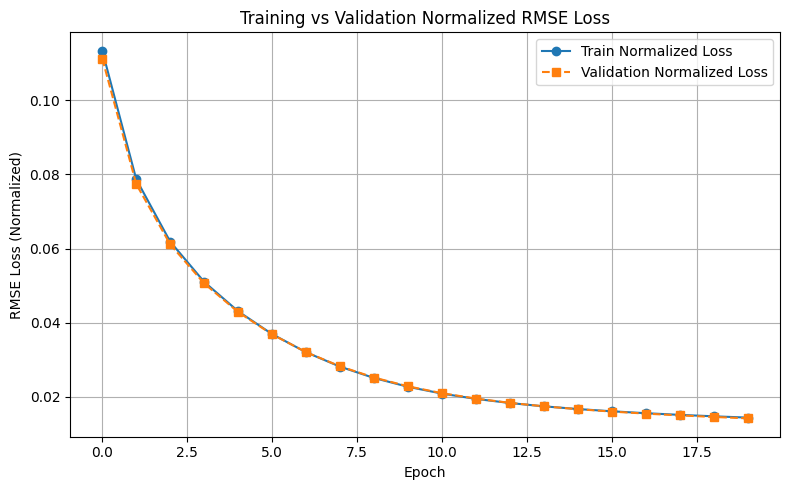

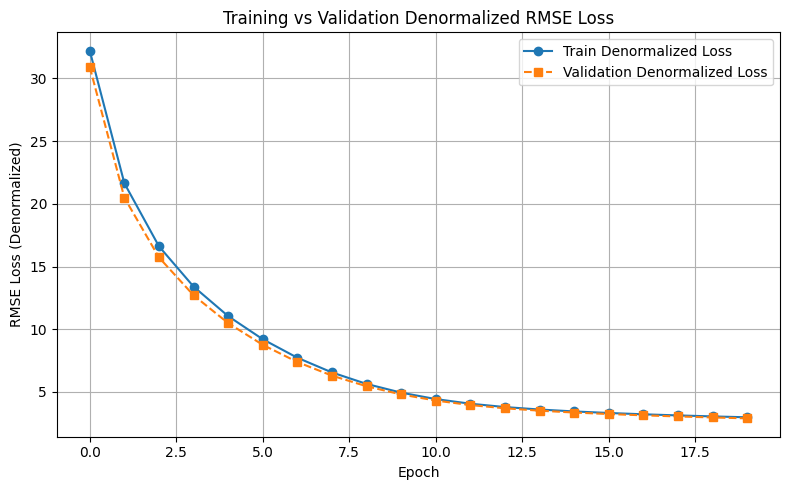

In [ ]:
training_loss_plot(train_norm_losses, val_norm_losses, train_denorm_losses, val_denorm_losses)

In [ ]:
test_norm_loss, test_denorm_loss = eval_validation(model, test_norm)
print(f"Test RMSE (norm/denorm): {test_norm_loss:.4f} / {test_denorm_loss:.4f}")

Test RMSE (norm/denorm): 0.0151 / 2.9867


In [ ]:
def pred_vs_true_full_traj(model, test):
    records = []
    for sample_idx, (input_norm, target_norm) in enumerate(test_norm):
        pred_norm_seq = model.forward_sequence(input_norm).reshape(target_norm.shape)
        pred_denorm   = denormalize_global_out(pred_norm_seq)
        true_denorm   = denormalize_global_out(target_norm)
        for t in range(target_norm.shape[0]):
            records.append({
                'sample':   sample_idx,
                'timestep': t,
                'true_x':   true_denorm[t, 0],
                'true_y':   true_denorm[t, 1],
                'pred_x':   pred_denorm[t, 0],
                'pred_y':   pred_denorm[t, 1],
            })
    return pd.DataFrame.from_records(records)

In [ ]:
df_full = pred_vs_true_full_traj(model, test)
print(df_full.head(10))

   sample  timestep  true_x   true_y     pred_x      pred_y
0       0         0  17.091  345.910  16.522277  335.488120
1       0         1  17.076  348.019  16.537790  342.442887
2       0         2  17.055  350.154  16.353060  344.353361
3       0         3  17.126  352.318  16.655458  345.693338
4       0         4  17.244  354.551  16.528472  347.130266
5       1         0  13.709  495.388  13.513470  485.796800
6       1         1  13.679  497.370  13.539515  488.856722
7       1         2  13.739  499.423  13.196622  493.583064
8       1         3  13.860  501.607  13.291384  499.135331
9       1         4  14.057  503.906  13.430755  491.163825


In [ ]:
import matplotlib.pyplot as plt

def trajectory_plot(model, dataset, samples, min_x_variation=None):
    """
    Plots the first `samples` trajectories from `dataset`, optionally
    filtering to only those with lateral movement ≥ min_x_variation.

    Uses global train‐set statistics for normalization/denormalization.
    """
    # determine valid indices based on raw target_seq
    if min_x_variation is not None:
        valid_indices = [
            i for i, (_, target_seq) in enumerate(dataset)
            if (target_seq[:, 0].max() - target_seq[:, 0].min()) >= min_x_variation
        ]
    else:
        valid_indices = list(range(len(dataset)))

    n = min(samples, len(valid_indices))
    if n == 0:
        print("No samples meet the filtering criteria.")
        return

    chosen = valid_indices[:n]

    for index, i in enumerate(chosen, start=1):
        input_seq, target_seq = dataset[i]

        # normalize with global stats
        input_norm  = normalize_global_in(input_seq)
        target_norm = normalize_global_out(target_seq)

        # predict in normalized space, then denormalize
        pred_norm_seq = model.forward_sequence(input_norm).reshape(target_norm.shape)
        pred_denorm   = denormalize_global_out(pred_norm_seq)
        true_denorm   = denormalize_global_out(target_norm)

        # plot
        plt.figure(figsize=(5, 5))
        plt.plot(true_denorm[:, 0], true_denorm[:, 1], 'o-', label='Actual')
        plt.plot(pred_denorm[:, 0], pred_denorm[:, 1], 's--', label='Predicted')
        plt.title(f"Sample {index} (dataset index={i})")
        plt.xlabel("Local_X")
        plt.ylabel("Local_Y")
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()


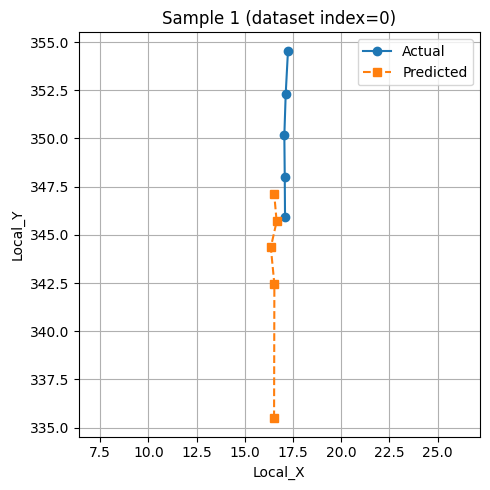

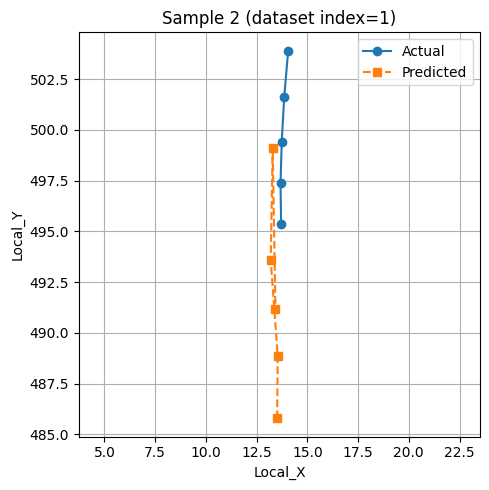

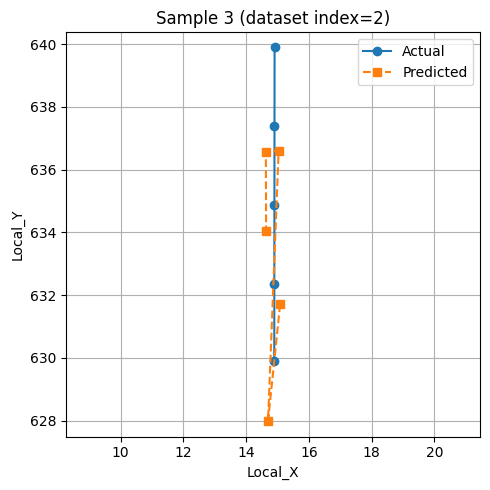

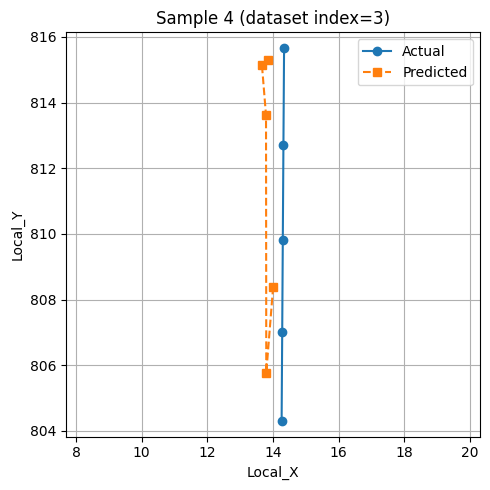

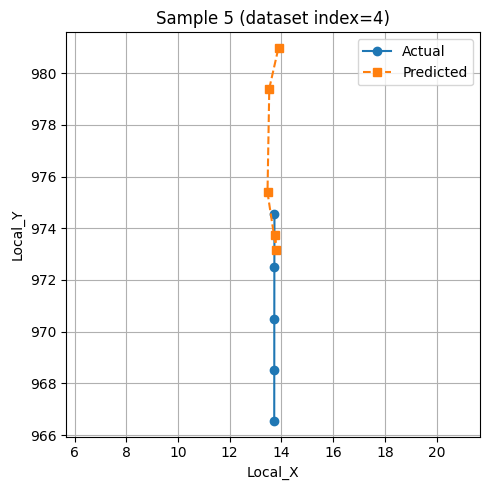

In [ ]:
trajectory_plot(model, test, samples=5)

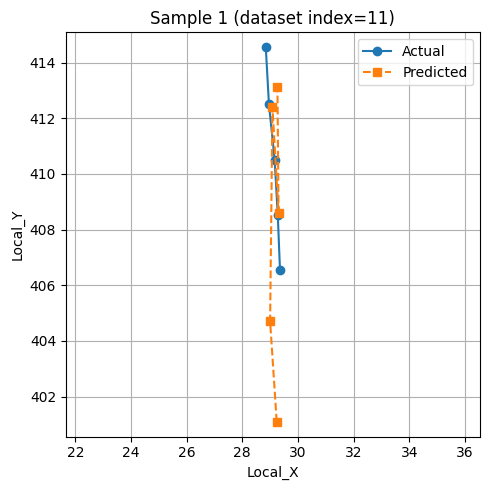

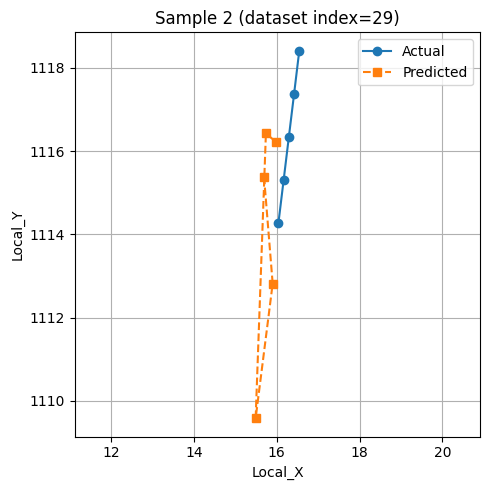

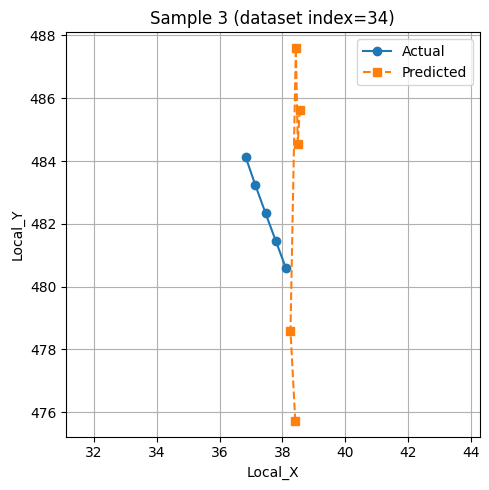

In [ ]:
trajectory_plot(model, test,samples=3, min_x_variation=0.5)